In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
file_path = 'phpkIxskf.arff'
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].str.decode('utf-8')

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Class
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown,1
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown,1
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown,1
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0.0,unknown,1
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5.0,may,198.0,1.0,-1.0,0.0,unknown,1


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

class NameChanger(BaseEstimator, TransformerMixin):
    # Changing the headers with the coressponding description to make more sense.
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.rename(
            columns= {'V1':'age', 
              'V2':'job', 
              'V3':'marital',
              'V4':'education',
              'V5':'credit_default',
              'V6':'balance',
              'V7':'housing_loan',
              'V8':'personal_loan',
              'V9':'communication_type',
              'V10':'last_contact_day',
              'V11':'last_contact_month',
              'V12':'last_contact_duration',
              'V13':'number_of_contacts',
              'V14':'pdays',
              'V15':'previous_contacts',
              'V16':'previous_outcome',
              'Class':'term_deposit'}, inplace=True
        )

class Contact_Date(BaseEstimator, TransformerMixin):
    # Combining last_contact_day and last_contact_month making a new column called last_contact_date
    # While also dropping last_contact_day and last_contact month as it is assumed not needed
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['last_contact_date'] = X['last_contact_day'].astype(int).astype(str) + ' ' + X['last_contact_month'].str.capitalize()
        X['last_contact_date'] = pd.to_datetime(X['last_contact_date'], format='%d %b')
        
        # This line below is to solve the error when fitting the dataset to a Logistic Regression
        X['last_contact_date'] = X['last_contact_date'].apply(lambda x: x.toordinal())
        
        # Drop the original columns
        X.drop(['last_contact_day', 'last_contact_month'], axis=1, inplace=True)
        
        # Return the modified DataFrame
        return X
    
class Convert_Binary(BaseEstimator, TransformerMixin):
    # Applying OrdinalEncoder to any columns with the values of 'yes' or 'no'
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in X.columns:
            if set(X[col].unique()) == {'yes', 'no'}:
                enc = OrdinalEncoder(categories=[['no', 'yes']])
                X[col] = enc.fit_transform(X[[col]]).astype(int)
        return X
    
class Target_Encoder(BaseEstimator, TransformerMixin):
    # WARNING: NameChanger() must be applied first
    # Applying OrdinalEncoder to X['term_deposit'] to normalize the data
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        enc = OrdinalEncoder()
        X['term_deposit'] = enc.fit_transform(X[['term_deposit']]).astype(int)
        return X

class Floats_to_Ints(BaseEstimator, TransformerMixin):
    # Converting any columns with the dtype floats to integers
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        for col in X.columns:
            if X[col].dtype == 'float64':
                X[col] = X[col].astype(int)
        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    # WARNING: last_contact_date and Target_Encoder must be applied first
    # Applies OneHotEncoder to any columns that has dtype = object and does NOT have 'yes' or 'no values
    # While also creating a a column header name based on its unique values + original column header name
    # Then dropping the original column from the dataframe
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ohe = OneHotEncoder()
        for col in X.columns:
            if X[col].dtype == 'object' and set(X[col].unique()) != {'yes', 'no'}:
                unique_values = X[col].unique()
                column_names = [str(value) for value in unique_values]

                matrix = ohe.fit_transform(X[[col]]).toarray()
                for i in range(len(matrix.T)):
                    X[str(col) + '_' + column_names[i]] = matrix.T[i]

                X = X.drop([col], axis=1)
        return X
    
class Reindexing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Putting term_deposit to the last column
        X['term_deposit'] = X.pop('term_deposit')
        return X

In [4]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("Contact_Date", Contact_Date()),
    ("Converting_yes_no", Convert_Binary()),
    ("Target_Encode", Target_Encoder()),
    ("Encoder", FeatureEncoder()),
    ("Floats_to_Ints", Floats_to_Ints()),
    ("Reindexing", Reindexing())
])

# The reason for using NameChanger seperately is because when it is applied to the pipeline
# It returns a TypeError: NoneType still don't know why and still researching as to why
NameChanger().fit_transform(df)

df = pipe.fit_transform(df)
df

,age,credit_default,balance,housing_loan,personal_loan,last_contact_duration,number_of_contacts,pdays,previous_contacts,last_contact_date,...,education_unknown,education_primary,communication_type_unknown,communication_type_cellular,communication_type_telephone,previous_outcome_unknown,previous_outcome_failure,previous_outcome_other,previous_outcome_success,term_deposit
0,58,0,2143,1,0,261,1,-1,0,693720,...,1,0,0,0,1,0,0,0,1,0
1,44,0,29,1,0,151,1,-1,0,693720,...,0,0,0,0,1,0,0,0,1,0
2,33,0,2,1,1,76,1,-1,0,693720,...,0,0,0,0,1,0,0,0,1,0
3,47,0,1506,1,0,92,1,-1,0,693720,...,0,1,0,0,1,0,0,0,1,0
4,33,0,1,0,0,198,1,-1,0,693720,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,977,3,-1,0,693916,...,1,0,1,0,0,0,0,0,1,1
45207,71,0,1729,0,0,456,2,-1,0,693916,...,0,0,1,0,0,0,0,0,1,1
45208,72,0,5715,0,0,1127,5,184,3,693916,...,0,0,1,0,0,0,0,1,0,1
45209,57,0,668,0,0,508,4,-1,0,693916,...,0,0,0,1,0,0,0,0,1,0


## Logistic Regression

In [5]:
features_list = [col for col in df.columns if col != 'term_deposit']
features = df[features_list]
target = df[['term_deposit']]

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Using StratifiedKFold just in case the data is imbalanced
skf = StratifiedKFold(n_splits=5, shuffle=True)

skf.get_n_splits(features, target)

fold = 0
aucs = []
# Loop through the splits generated by StratifiedKFold
for train_index, test_index in skf.split(features, target):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Initialize and fit the Logistic Regression model
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train.values.ravel())
    
    # Getting the predictions and predict probability
    logreg_y_pred = log_reg.predict(X_test)
    logreg_y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

    # Evaluate the model's accuracy
    logreg_acc_score = accuracy_score(y_test, logreg_y_pred)
    logreg_auc_score = roc_auc_score(y_test, logreg_y_pred_prob)
    
    print(f"======= Fold {fold} ========")
    print(
        f"Accuracy on the validation set is {logreg_acc_score:0.4f} and AUC is {logreg_auc_score:0.4f}"
    )
    fold += 1
    aucs.append(logreg_auc_score)

logreg_avg_auc = np.mean(aucs)
print(f'Average AUC score is {logreg_avg_auc:0.4f}')

======= Fold 0 ========
Accuracy on the validation set is 0.8915 and AUC is 0.8249
======= Fold 1 ========
Accuracy on the validation set is 0.8861 and AUC is 0.8107
======= Fold 2 ========
Accuracy on the validation set is 0.8905 and AUC is 0.8156
======= Fold 3 ========
Accuracy on the validation set is 0.8886 and AUC is 0.8159
======= Fold 4 ========
Accuracy on the validation set is 0.8913 and AUC is 0.8370
Average AUC score is 0.8208


## SVM

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

# As much as I want to do GridSearchCV or RandomizedSearchCV
# The specs of my computer isn't strong enough to do the calculation, as from my calculation 
# It will take me about 2516 days using GridSearch CV and using RandomizedSearchCV would take me 7.3 days
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", svm.SVC(C=1, gamma='auto', max_iter=10000)),
    ])

fold = 0
aucs = []
# Loop through the splits generated by StratifiedKFold
for train_index, test_index in skf.split(features, target):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Initialize and fit the Linear SVC
    svm_clf.fit(features, target.values.ravel())
    
    # Getting the predictions and predict probability
    svm_y_pred = svm_clf.predict(X_test)
    svm_y_pred_proba = svm_clf.decision_function(X_test)
    
    # Evaluate the model's accuracy
    svm_acc_score = accuracy_score(y_test, svm_y_pred)
    svm_auc_score = roc_auc_score(y_test, svm_y_pred_proba)
    
    print(f"======= Fold {fold} ========")
    print(
        f"Accuracy on the validation set is {svm_acc_score:0.4f} and AUC is {svm_auc_score:0.4f}"
    )
    fold += 1
    aucs.append(svm_auc_score)

svm_avg_auc = np.mean(aucs)
print(f'Average AUC score is {svm_avg_auc:0.4f}')

C:\Users\ThinkPad\anaconda3\envs\bank_marketing\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


======= Fold 0 ========
Accuracy on the validation set is 0.9071 and AUC is 0.8994


C:\Users\ThinkPad\anaconda3\envs\bank_marketing\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


======= Fold 1 ========
Accuracy on the validation set is 0.9053 and AUC is 0.8985


C:\Users\ThinkPad\anaconda3\envs\bank_marketing\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


======= Fold 2 ========
Accuracy on the validation set is 0.9050 and AUC is 0.8988


C:\Users\ThinkPad\anaconda3\envs\bank_marketing\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


======= Fold 3 ========
Accuracy on the validation set is 0.9083 and AUC is 0.9158


C:\Users\ThinkPad\anaconda3\envs\bank_marketing\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


======= Fold 4 ========
Accuracy on the validation set is 0.9052 and AUC is 0.9113
Average AUC score is 0.9048


## Accuracy Plot Comparison

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7984
           1       0.73      0.30      0.43      1058

    accuracy                           0.91      9042
   macro avg       0.82      0.64      0.69      9042
weighted avg       0.89      0.91      0.89      9042

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      7984
           1       0.12      0.03      0.05      1058

    accuracy                           0.86      9042
   macro avg       0.50      0.50      0.49      9042
weighted avg       0.79      0.86      0.82      9042



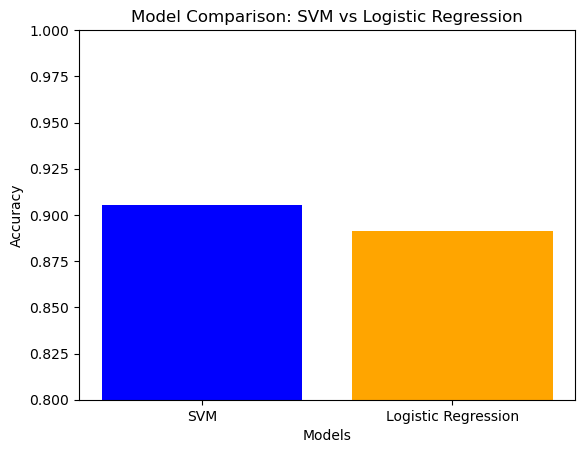

In [7]:
from sklearn.metrics import classification_report

# Printing classification reports
print("SVM Classification Report:")
print(classification_report(y_test, svm_y_pred))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, logreg_y_pred))

# Creating a plot for comparison
labels = ['SVM', 'Logistic Regression']
accuracies = [svm_acc_score, logreg_acc_score]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: SVM vs Logistic Regression')
plt.ylim(0.8, 1.0)  # Set y-axis limit from 0 to 1 for accuracy
plt.show()

## Correlation Analysis (Spearman)

<Axes: >

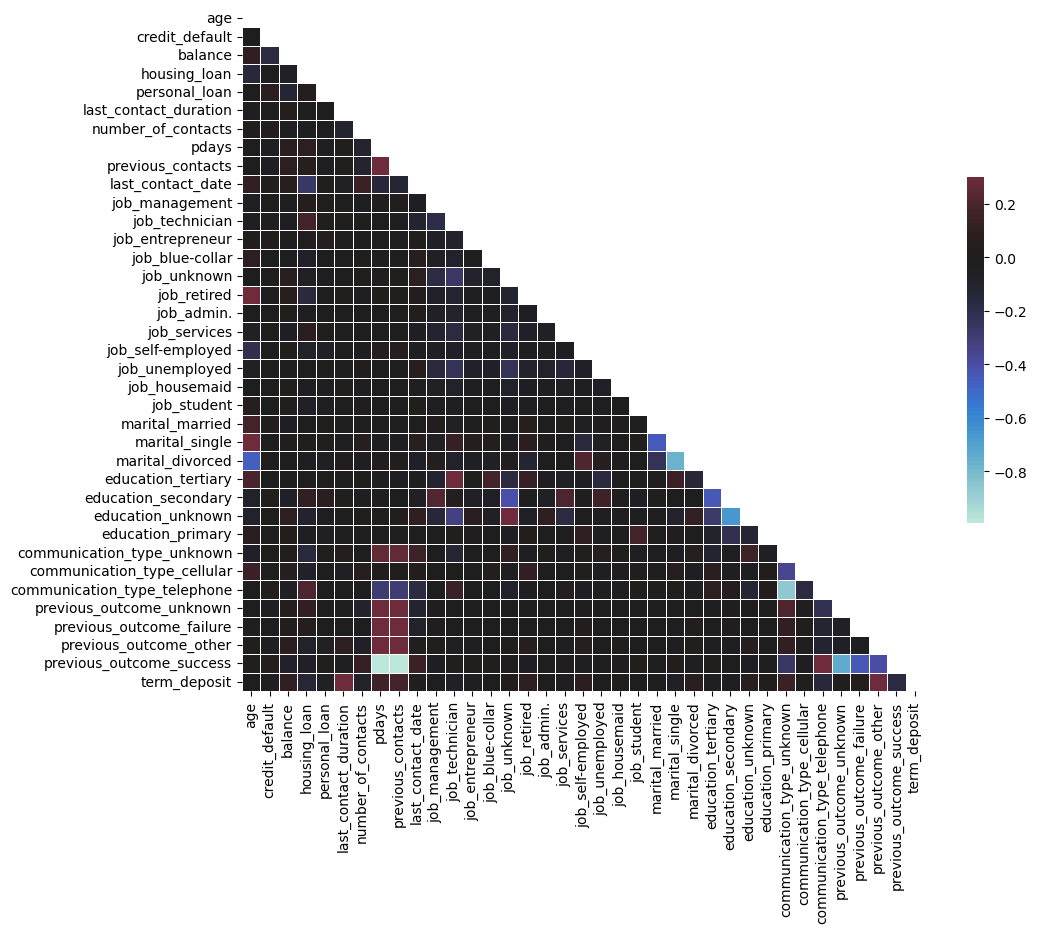

In [10]:
import seaborn as sns

corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(df.corr(method="spearman")))

fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr,
            mask=mask,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5}
               )